<a href="https://colab.research.google.com/github/jhy9968/ECE6179_project/blob/main/Baseline_resnet18_AutoEncoder_GAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1> ECE4179 - Semi-Supervised Learning Project</h1>
<h2>Data</h2>

We will be using a dataset that can be obtained directly from the torchvision package. There are 10 classes and we will be training a CNN for the image classification task. We have training, validation and test sets that are labelled with the class, and a large unlabeled set.

We will simulating a low training data scenario by only sampling a small percentage of the labelled data (10%) as training data. The remaining examples will be used as the validation set.

To get the labelled data, change the dataset_dir to something suitable for your machine, and execute the following (you will then probably want to wrap the dataset objects in a PyTorch DataLoader):

In [1]:
import torch
from torchvision.datasets import STL10 as STL10
import torchvision.transforms as transforms
from torch.utils.data import random_split
!pip install torchmetrics
from torchmetrics import Accuracy
import torchvision
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from google.colab import drive
drive.mount('/content/drive/')

####### CHANGE TO APPROPRIATE DIRECTORY TO STORE DATASET
root_dir = "/content/drive/Shareddrives/ECE6179_project/"
dataset_dir = root_dir + "CNN-VAE/data/"
#For MonARCH
# dataset_dir = "/mnt/lustre/projects/ds19/SHARED"

#All images are 3x96x96
image_size = 96
#Example batch size
batch_size = 32

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 8.3 MB/s 
Mounted at /content/drive/


<h3>Create the appropriate transforms</h3>

In [2]:
#Perform random crops and mirroring for data augmentation
transform_train = transforms.Compose(
    [transforms.RandomCrop(image_size, padding=4),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_unlabelled = transforms.Compose(
    [transforms.RandomHorizontalFlip(p=0.5),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

#No random 
transform_test = transforms.Compose(
    [transforms.CenterCrop(image_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


<h3>Create training and validation split</h3>

In [3]:
#Load train and validation sets
trainval_set = STL10(dataset_dir, split='train', transform=transform_train, download=True)

#Use 10% of data for training - simulating low data scenario
num_train = int(len(trainval_set)*0.1)

#Split data into train/val sets
torch.manual_seed(0) #Set torch's random seed so that random split of data is reproducible
train_set, val_set = random_split(trainval_set, [num_train, len(trainval_set)-num_train])

#Load test set
test_set = STL10(dataset_dir, split='test', transform=transform_test, download=True)

Files already downloaded and verified
Files already downloaded and verified


<h3>Get the unlabelled data</h3>

In [5]:
unlabelled_set = STL10(dataset_dir, split='unlabeled', transform=transform_unlabelled, download=True)

Files already downloaded and verified


You may find later that you want to make changes to how the unlabelled data is loaded. This might require you sub-classing the STL10 class used above or to create your own dataloader similar to the Pytorch one.
https://pytorch.org/docs/stable/_modules/torchvision/datasets/stl10.html#STL10

<h3>Create the four dataloaders</h3>

In [6]:
from torch.utils.data import DataLoader

#batch_size = 500
train_loader = DataLoader(train_set, shuffle=True, batch_size=batch_size)
unlabelled_loader = DataLoader(unlabelled_set, shuffle=True, batch_size=batch_size)

val_loader = DataLoader(val_set, batch_size=batch_size)
test_loader  = DataLoader(test_set, batch_size=batch_size)

print('Size of train loader:', len(train_loader))
print('Size of unlabelled loader:', len(unlabelled_loader))
print('Size of valid loader:', len(val_loader))
print('Size of test loader:', len(test_loader))

Size of train loader: 16
Size of unlabelled loader: 3125
Size of valid loader: 141
Size of test loader: 250


In [7]:
train_data_iter = iter(unlabelled_loader)
data,labels = train_data_iter.next()
print(data.shape)
print(labels.shape)

torch.Size([32, 3, 96, 96])
torch.Size([32])


## Network

Let's use a ResNet18 architecture for our CNN...

In [8]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

cuda:0
Mon Sep 26 01:51:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+

In [9]:
! pip install --quiet "matplotlib" "pytorch-lightning" "pandas" "torchmetrics"
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from torch import Tensor
import torch.nn as nn
from torchmetrics import Accuracy
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks.progress import TQDMProgressBar
from pytorch_lightning.loggers import CSVLogger
from torch.nn import functional as F
from torchmetrics import MeanSquaredError
from pytorch_lightning.callbacks import Callback, ModelCheckpoint
import torchvision.models.resnet as RN

     |████████████████████████████████| 708 kB 7.7 MB/s 
     |████████████████████████████████| 5.9 MB 57.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2+zzzcolab20220719082949 requires tensorboard<2.9,>=2.8, but you have tensorboard 2.10.0 which is incompatible.


In [10]:
class Encoder(nn.Module):
  def __init__ (self, inplanes = 64, outplanes = 64 ):
    super(Encoder, self).__init__()

    # self.learning_rate = learning_rate
    # self.loss_fun      = nn.CrossEntropyLos()

    # self.train_loader  = train_loader
    # self.val_loader    = val_loader
    # self.test_loader   = test_loader
    self.inplanes      = inplanes
    self.outplanes     = outplanes

    self.conv1         = nn.Conv2d(in_channels= 3, out_channels = self.inplanes, kernel_size = 7, stride=2, padding=3, bias = False)
    self.bn1           = nn.BatchNorm2d(self.inplanes)
    self.relu           = F.relu
    self.maxpool       = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    
    self.BasicBlock1   = RN.BasicBlock(inplanes = self.inplanes,  planes = self.outplanes)
    self.BasicBlock2   = RN.BasicBlock(inplanes = self.outplanes, planes = self.outplanes)

  def forward(self, x):

    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.BasicBlock1(x)
    x = self.BasicBlock2(x)

    return x


In [11]:
class Decoder(nn.Module):
  def __init__ (self, inplanes = 64, intMed_planes = 64):
    super(Decoder, self).__init__()
    self.inplanes      = inplanes
    self.intMed_planes = intMed_planes

    self.convTrans1 = nn.ConvTranspose2d(in_channels = self.inplanes, out_channels = self.intMed_planes, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
    self.conv2 = nn.Conv2d(in_channels = self.intMed_planes, out_channels = self.intMed_planes, kernel_size = 3, stride = 1, padding = 1)
    self.convTrans3 = nn.ConvTranspose2d(in_channels = self.intMed_planes, out_channels = self.intMed_planes, kernel_size = 3, stride = 2, padding = 1, output_padding=1)
    self.conv4 = nn.Conv2d(in_channels = self.intMed_planes, out_channels = 3, kernel_size = 3, stride = 1, padding = 1)

 # Output padding is here to match the size. It needs to be careful on this extra line of zeros when building the loss function.

  def forward (self, x):
    
    x = self.convTrans1(x)
    x = self.conv2(x)
    x = self.convTrans3(x)
    x = self.conv4(x)

    return x



In [12]:
class AutoEncoder(LightningModule):
  def __init__ (self, learning_rate = 1e-4, trainDataLoader=unlabelled_loader, valDataLoader=val_loader, testDataLoader=test_loader):
    super().__init__()

    self.learning_rate = learning_rate
    self.loss_fun = nn.MSELoss()

    self.Encoder = Encoder(64, 64)
    self.Decoder = Decoder(64, 64)

    self.train_accuracy = MeanSquaredError()
    self.val_accuracy = MeanSquaredError()
    self.test_accuracy = MeanSquaredError()

    self.trainDataLoader = trainDataLoader
    self.valDataLoader = valDataLoader
    self.testDataLoader = testDataLoader
    

  def forward(self, x):
#    print(x.shape)
    out = self.Encoder(x)
#    print(out.shape)
    out = self.Decoder(out)
#    print(out.shape)
    out_flattened = out.view(x.shape[0], -1)
#    print(out_flattened.shape)
    return out_flattened

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    x_flattened = x.view(x.shape[0], -1)

    loss = self.loss_fun(logits, x_flattened)
    self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    #self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    x_flattened = x.view(x.shape[0], -1)

    loss = self.loss_fun(logits, x_flattened)
    self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    #self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True) 
  
  def test_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    x_flattened = x.view(x.shape[0], -1)

    loss = self.loss_fun(logits, x_flattened)
    self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    #self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True) 

  def configure_optimizers(self):
    optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)

    return optimizer
  
  def train_dataloader(self):    
    return self.trainDataLoader
  
  def val_dataloader(self):
    return self.valDataLoader
  
  def test_dataloader(self):
    return self.testDataLoader

  def extractSubModules(self):
    return self.Encoder, self.Decoder

In [ ]:


Max_Epochs = 250
Case_Dir = "BaseCase_AutoEncoder_ver001/"
checkpoint_callback = ModelCheckpoint(monitor = "val_acc",
                                      dirpath = root_dir+ Case_Dir,
                                      save_top_k=1,
                                      mode="max",
                                      every_n_epochs=1
                                      )
print(root_dir+ Case_Dir)

model_AutoEncoder_v001 = AutoEncoder(learning_rate = 2e-5, trainDataLoader=unlabelled_loader, valDataLoader=val_loader, testDataLoader=test_loader)
checkpoint_dir = root_dir+ Case_Dir+"lightning_logs/version_7/checkpoints/epoch=199-step=199200.ckpt"

trainer_AutoEncoder = Trainer(
    accelerator="auto",
    devices = 1 if torch.cuda.is_available() else None,
    max_epochs = Max_Epochs,
    callbacks = [TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir= root_dir+ Case_Dir),
    deterministic=True
)

trainer_AutoEncoder.fit(model_AutoEncoder_v001, ckpt_path=checkpoint_dir )

# Evaluate Model
trainer_AutoEncoder.test()

# Save Encoder & Decoder

model_AutoEncoder_v001.freeze()
model_path = root_dir+ Case_Dir+ "Models/"
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

enc, dec = model_AutoEncoder_v001.extractSubModules()
torch.save(model_AutoEncoder_v001.state_dict(), model_path+timestamp+"_AE_v001_mod.pth")
torch.save(enc.state_dict(), model_path+timestamp+"_AE_v001_enc.pth")
torch.save(dec.state_dict(), model_path+timestamp+"_AE_v001_dec.pth")

/content/drive/Shareddrives/ECE6179_project/BaseCase_AutoEncoder_ver001/


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/Shareddrives/ECE6179_project/BaseCase_AutoEncoder_ver001/lightning_logs/version_7/checkpoints/epoch=199-step=199200.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type             | Params
----------------------------------------------------
0 | loss_fun       | MSELoss          | 0     
1 | Encoder        | Encoder          | 157 K 
2 | Decoder        | Decoder          | 112 K 
3 | train_accuracy | MeanSquaredError | 0     
4 | vald_accuracy  | MeanSquaredE

Sanity Checking: 0it [00:00, ?it/s]

Training: 1000it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=250` reached.
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/Shareddrives/ECE6179_project/BaseCase_AutoEncoder_ver001/lightning_logs/version_8/checkpoints/epoch=249-step=209200.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/Shareddrives/ECE6179_project/BaseCase_AutoEncoder_ver001/lightning_logs/version_8/checkpoints/epoch=249-step=209200.ckpt


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss          0.005031408276408911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


torch.Size([32, 3, 96, 96])


torch.Size([32, 3, 96, 96])


Text(0.5, 1.0, 'Recovered Images')

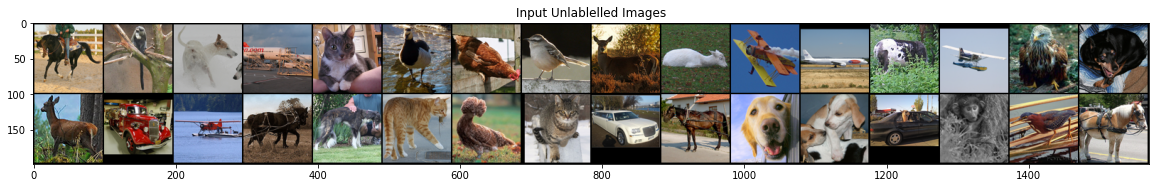

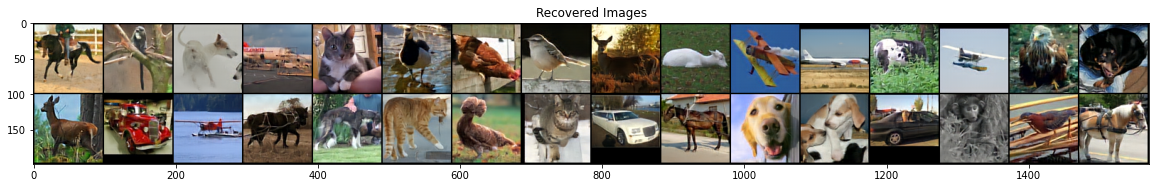

In [13]:
enc_rec = Encoder()
dec_rec = Decoder()

Case_Dir = "BaseCase_AutoEncoder_ver001/"
path = root_dir+ Case_Dir+ "Models/"

enc_rec_statdic = torch.load(path+"20220924175716_AE_v001_enc.pth")
dec_rec_statdic = torch.load(path+"20220924175716_AE_v001_dec.pth")


enc_rec.load_state_dict(enc_rec_statdic)
dec_rec.load_state_dict(dec_rec_statdic)

test_data_iter = iter(test_loader)
data,labels = test_data_iter.next()

print(data[:64].shape)

with torch.no_grad():
  x = enc_rec.forward(data[:64])
  y = dec_rec.forward(x)




# Plot the figures
print(y.shape)

inv_normalize = transforms.Normalize(
                    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
                    std=[1/0.5, 1/0.5, 1/0.5]
                )

data_plot= inv_normalize(data[:64])
y_plot   = inv_normalize(y)

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(data_plot, nrow=16)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title("Input Unlablelled Images")

plt.figure(figsize = (20,10))
out = torchvision.utils.make_grid(y_plot, nrow=16)
plt.imshow(out.numpy().transpose((1, 2, 0)))
plt.title("Recovered Images")



In [54]:
enc_Module = Encoder()
dec_Module = Decoder()

Case_Dir = "BaseCase_AutoEncoder_ver001/"
path = root_dir+ Case_Dir+ "Models/"

enc_Module_statdic = torch.load(path+"20220924175716_AE_v001_enc.pth")
dec_Module_statdic = torch.load(path+"20220924175716_AE_v001_dec.pth")


enc_rec.load_state_dict(enc_rec_statdic)
dec_rec.load_state_dict(dec_rec_statdic)


class AutoEncoder_Classifier(LightningModule):
  def __init__ (self, learning_rate = 1e-3,
                encParm= enc_Module_statdic, # decParm = dec_Module_statdic, 
                trainDataLoader=train_loader, valDataLoader=val_loader, testDataLoader=test_loader):
    super().__init__()

    self.learning_rate = learning_rate
    self.loss_fun = nn.CrossEntropyLoss()

    self.Encoder = Encoder(64, 64)
    self.Encoder.load_state_dict(encParm)

    #self.Decoder = Decoder(64, 64).load_state_dict(decParm)

    self.act     = F.relu
    self.GAP     = nn.AdaptiveAvgPool2d(8)
    self.linear1 = nn.Linear(4096, 512)
    self.linear2 = nn.Linear(512, 10)

    self.train_accuracy = Accuracy()
    self.val_accuracy = Accuracy()
    self.test_accuracy = Accuracy()

    self.trainDataLoader = trainDataLoader
    self.valDataLoader = valDataLoader
    self.testDataLoader = testDataLoader
    

  def forward(self, x):
    out = self.Encoder(x)
    out = self.GAP(out)
    out = out.view(out.shape[0], -1)
    out = self.linear1(out)
    out = self.act(out)
    out = self.linear2(out)

    return out

  def training_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = self.loss_fun(logits, y)

    preds = logits.argmax(1)
    self.train_accuracy.update(preds, y)

    self.log("train_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    self.log("train_acc", self.train_accuracy, prog_bar=True, on_step=False, on_epoch=True)

    return loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = self.loss_fun(logits, y)

    preds = logits.argmax(1)
    self.val_accuracy.update(preds, y)
    self.log("val_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    self.log("val_acc", self.val_accuracy, prog_bar=True, on_step=False, on_epoch=True) 
  
  def test_step(self, batch, batch_idx):
    x, y = batch
    logits = self.forward(x)
    loss = self.loss_fun(logits, y)

    preds = logits.argmax(1)
    self.test_accuracy.update(preds, y)
    self.log("test_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
    self.log("test_acc", self.test_accuracy, prog_bar=True, on_step=False, on_epoch=True) 

  def configure_optimizers(self):
    trainable_parameters = []
    for name, p in self.named_parameters():
        if "Encoder" not in name:
            trainable_parameters.append(p)
            print(name)

    # optimizer = torch.optim.SGD(params=trainable_parameters, lr=0.1, momentum=1e-5)
    optimizer = torch.optim.Adam(params=trainable_parameters, lr=self.learning_rate)

    return optimizer
  
  def train_dataloader(self):    
    return self.trainDataLoader
  
  def val_dataloader(self):
    return self.valDataLoader
  
  def test_dataloader(self):
    return self.testDataLoader

  def extractSubModules(self):
    return self.Encoder, self.linear1, self.linear2

In [55]:
Max_Epochs = 100
Case_Dir = "BaseCase_AutoEncoder_ver001/Classifier_ver001/"
checkpoint_callback = ModelCheckpoint(monitor = "val_acc",
                                      dirpath = root_dir+ Case_Dir,
                                      save_top_k=1,
                                      mode="max",
                                      every_n_epochs=1
                                      )
print(root_dir+ Case_Dir)

train_loader_mod = DataLoader(train_set, shuffle=True, batch_size=batch_size)
unlabelled_loader = DataLoader(unlabelled_set, shuffle=True, batch_size=batch_size)


model_AE_Classifier_v001 = AutoEncoder_Classifier(learning_rate = 1e-3, trainDataLoader=train_loader, valDataLoader=val_loader, testDataLoader=test_loader)
#checkpoint_dir = root_dir+ Case_Dir+"lightning_logs/version_7/checkpoints/epoch=199-step=199200.ckpt"

trainer_AE_Classfier = Trainer(
    accelerator="auto",
    devices = 1 if torch.cuda.is_available() else None,
    max_epochs = Max_Epochs,
    callbacks = [TQDMProgressBar(refresh_rate=20)],
    logger=CSVLogger(save_dir= root_dir+ Case_Dir),
    deterministic=False,
    log_every_n_steps=16
)

trainer_AE_Classfier.fit(model_AE_Classifier_v001 )

# Evaluate Model
trainer_AE_Classfier.test()

# Save Encoder & Decoder

model_AE_Classifier_v001.freeze()
model_path = root_dir+ Case_Dir+ "Models/"
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

enc, lin1, lin2 = model_AE_Classifier_v001 .extractSubModules()
torch.save(model_AE_Classifier_v001.state_dict(), model_path+timestamp+"_AEC_v001_mod.pth")
torch.save(enc.state_dict(), model_path+timestamp+"_AEC_v001_enc.pth")
torch.save(lin1.state_dict(), model_path+timestamp+"_AEC_v001_lin1.pth")
torch.save(lin2.state_dict(), model_path+timestamp+"_AEC_v001_lin2.pth")

/content/drive/Shareddrives/ECE6179_project/BaseCase_AutoEncoder_ver001/Classifier_ver001/


INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name           | Type              | Params
-----------------------------------------------------
0 | loss_fun       | CrossEntropyLoss  | 0     
1 | Encoder        | Encoder           | 157 K 
2 | GAP            | AdaptiveAvgPool2d | 0     
3 | linear1        | Linear            | 2.1 M 
4 | linear2        | Linear            | 5.1 K 
5 | train_accuracy | Accuracy          | 0     
6 | val_accuracy   | Accuracy          | 0     
7 | test_accuracy  | Accuracy          | 0     
-----------------------------------------------------
2.3 M

linear1.weight
linear1.bias
linear2.weight
linear2.bias


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1390: UserWarning: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
  + f" You can pass `.{fn}(ckpt_path='best')` to use the best model or"
INFO:pytorch_lightning.utilities.rank_zero:Restoring states from the checkpoint path at /content/drive/Shareddrives/ECE6179_project/BaseCase_AutoEncoder_ver001/Classifier_ver001/lightning_logs/version_15/checkpoints/epoch=99-step=1600.ckpt
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.utilities.rank_zero:Loaded model weights from checkpoint at /content/drive/Shareddrives/ECE6179_project/BaseCase_AutoEncod

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.5199999809265137
        test_loss           2.4817137718200684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [ ]:
'''
def train_one_epoch(epoch_index):
    running_loss = 0.
    running_acc = 0.
    last_loss = 0.
    last_acc = 0.

    for i, data in enumerate(train_loader):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimiser.zero_grad()

        x = Encoder(inputs)
        x = Decoder(x)

        outputs = x

        inputsLinear  = inputs.view (inputs.shape[0], -1)
        outputsLinear = outputs.view(outputs.shape[0],-1)

        loss = loss_fn(outputsLinear, inputsLinear)
        # acc = accuracy(outputs, labels)
        loss.backward()

        optimiser.step()

        running_loss += loss.item()
        running_acc += acc.item()

    last_loss = running_loss / len(train_loader) # loss per batch
    last_acc = running_acc / len(train_loader) # accuracy per batch

    return last_loss, last_acc
  '''

'\ndef train_one_epoch(epoch_index):\n    running_loss = 0.\n    running_acc = 0.\n    last_loss = 0.\n    last_acc = 0.\n\n    for i, data in enumerate(train_loader):\n        inputs, labels = data\n        inputs = inputs.to(device)\n        labels = labels.to(device)\n\n        optimiser.zero_grad()\n\n        x = Encoder(inputs)\n        x = Decoder(x)\n\n        outputs = x\n\n        inputsLinear  = inputs.view (inputs.shape[0], -1)\n        outputsLinear = outputs.view(outputs.shape[0],-1)\n\n        loss = loss_fn(outputsLinear, inputsLinear)\n        # acc = accuracy(outputs, labels)\n        loss.backward()\n\n        optimiser.step()\n\n        running_loss += loss.item()\n        running_acc += acc.item()\n\n    last_loss = running_loss / len(train_loader) # loss per batch\n    last_acc = running_acc / len(train_loader) # accuracy per batch\n\n    return last_loss, last_acc\n  '

In [ ]:
'''
model = torchvision.models.resnet18()
model.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)
model = model.to(device)
'''

'\nmodel = torchvision.models.resnet18()\nmodel.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)\nmodel = model.to(device)\n'

In [ ]:
'''
EPOCHS = 100
LEARNING_RATE = 1e-2
best_vloss = 1_000_000.
best_vacc = 0.

timestamp = datetime.now().strftime('%Y%m%d')
writer = SummaryWriter(root_dir + 'Baseline_resnet18/runs/resnet18_trainer_{}_epochs_{}_lr_{}'.format(timestamp, EPOCHS, LEARNING_RATE))
epoch_number = 0
'''

"\nEPOCHS = 100\nLEARNING_RATE = 1e-2\nbest_vloss = 1_000_000.\nbest_vacc = 0.\n\ntimestamp = datetime.now().strftime('%Y%m%d')\nwriter = SummaryWriter(root_dir + 'Baseline_resnet18/runs/resnet18_trainer_{}_epochs_{}_lr_{}'.format(timestamp, EPOCHS, LEARNING_RATE))\nepoch_number = 0\n"

In [ ]:
# EPOCHS = 100
# LEARNING_RATE = 1e-2
# best_vloss = 1_000_000.
# best_vacc = 0.

# timestamp = datetime.now().strftime('%Y%m%d')
# writer = SummaryWriter(root_dir + 'Baseline_resnet18/runs/resnet18_trainer_{}_epochs_{}_lr_{}'.format(timestamp, EPOCHS, LEARNING_RATE))
# epoch_number = 0
'''
optimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
accuracy = Accuracy().to(device)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(EPOCHS):

    # Training
    model.train(True)
    avg_loss, avg_acc = train_one_epoch(epoch_number)

    # Validation
    model.train(False)
    running_vloss = 0.0
    running_vacc = 0.0
    with torch.no_grad():
      for i, vdata in enumerate(valid_loader):
          vinputs, vlabels = vdata
          vinputs = vinputs.to(device)
          vlabels = vlabels.to(device)
          voutputs = model(vinputs)
          vloss = loss_fn(voutputs, vlabels)
          vacc = accuracy(voutputs, vlabels)
          running_vloss += vloss
          running_vacc += vacc
    avg_vloss = running_vloss / (i + 1)
    avg_vacc = running_vacc / (i + 1)

    # Print and log the loss
    if epoch_number % 10 == 9:
      print('EPOCH {}:'.format(epoch_number + 1))
      print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
      print('ACC train {} valid {}'.format(avg_acc, avg_vacc))
      writer.add_scalars('Training vs. Validation Loss',
                      { 'Training' : avg_loss, 'Validation' : avg_vloss },
                      epoch_number + 1)
      writer.add_scalars('Training vs. Validation Accuracy',
                      { 'Training' : avg_acc, 'Validation' : avg_vacc },
                      epoch_number + 1)
      writer.flush()

    # Track best performance, and save the model's state
    if avg_vacc > best_vacc:
        best_vacc = avg_vacc
        model_path = root_dir + 'Baseline_resnet18/models/model_{}_{}_acc_{}'.format(timestamp, epoch_number, best_vacc)
        torch.save(model.state_dict(), model_path)

    epoch_number += 1
'''

"\noptimiser = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)\naccuracy = Accuracy().to(device)\nloss_fn = torch.nn.CrossEntropyLoss()\n\nfor epoch in range(EPOCHS):\n\n    # Training\n    model.train(True)\n    avg_loss, avg_acc = train_one_epoch(epoch_number)\n\n    # Validation\n    model.train(False)\n    running_vloss = 0.0\n    running_vacc = 0.0\n    with torch.no_grad():\n      for i, vdata in enumerate(valid_loader):\n          vinputs, vlabels = vdata\n          vinputs = vinputs.to(device)\n          vlabels = vlabels.to(device)\n          voutputs = model(vinputs)\n          vloss = loss_fn(voutputs, vlabels)\n          vacc = accuracy(voutputs, vlabels)\n          running_vloss += vloss\n          running_vacc += vacc\n    avg_vloss = running_vloss / (i + 1)\n    avg_vacc = running_vacc / (i + 1)\n\n    # Print and log the loss\n    if epoch_number % 10 == 9:\n      print('EPOCH {}:'.format(epoch_number + 1))\n      print('LOSS train {} valid {}'.format(avg_loss, a

In [ ]:
'''
# Testing
model.train(False)
running_tacc = 0.0
with torch.no_grad():
  for i, tdata in enumerate(test_loader):
      tinputs, tlabels = tdata
      tinputs = tinputs.to(device)
      tlabels = tlabels.to(device)
      toutputs = model(tinputs)
      tacc = accuracy(toutputs, tlabels)
      running_tacc += tacc
avg_tacc = running_tacc / (i + 1)
print('Testing ACC {}'.format(avg_tacc))
'''

NameError: ignored

In [ ]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
writer.add_graph(model, images.to(device))
writer.close()

In [ ]:
%tensorboard --logdir=/content/drive/Shareddrives/ECE6179_project/Baseline_resnet18/runs